We are going to build a image classifier using the Inceptionv3 model, that will be trained to used classify resume images from non-resume documents. We are using the pretrained model from keras library.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Resume_classifier'

/content/drive/MyDrive/Resume_classifier


In [ ]:
# Importing necessary libraries

import glob
import numpy as np
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import cv2

## Data Setting and Visualising

In [ ]:
# Visualising the data
import math
def show_images(image_list, n, title):
  row_num = math.ceil(n/3)

  for i, image in enumerate(image_list):
    img_bgr = cv2.imread(image)
    img_bgr = cv2.resize(img_bgr, (224, 224))
    plt.subplot(row_num, 3, i+1)
    # Color conversion to bgr
    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_bgr)
    plt.axis('off')

  plt.tight_layout()
  plt.suptitle(title)
  plt.show()


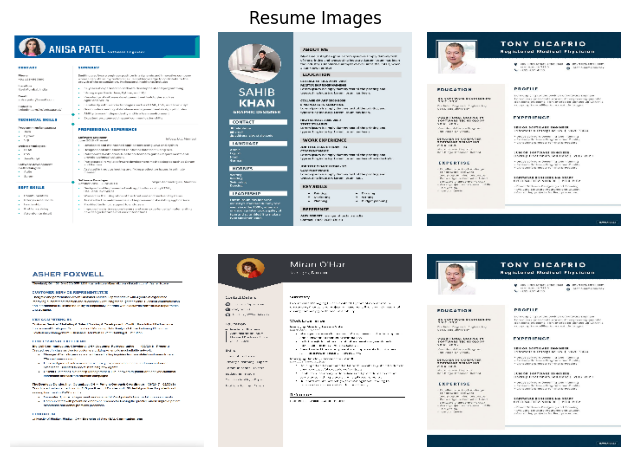

In [ ]:
# Resume Images

resume_image_list = glob.glob('/content/drive/MyDrive/Resume_classifier/train/Resume/*.*')[:6]
show_images(resume_image_list, 6, 'Resume Images')

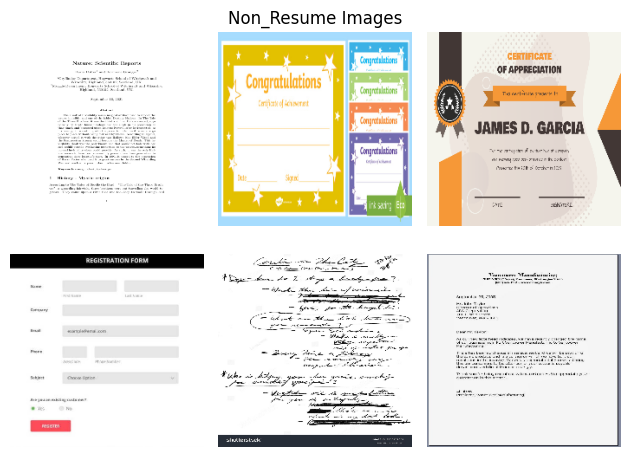

In [ ]:
# Non-Resume Images

non_resume_image_list = glob.glob('/content/drive/MyDrive/Resume_classifier/train/Non-resume/*.*')[:6]
show_images(non_resume_image_list, 6, 'Non_Resume Images')

## Data Preprocessing

We will be using the ImageDataGenerator function from keras to preprocess the data we have. The various transformations that we are going to use are : horizontal flip, zoom, shear transform, rotation by some specific angle, adjusting brightness and  rescaling.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range=0.3,
                                   brightness_range=(0.5, 1.5))

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_path = '/content/drive/MyDrive/Resume_classifier/train'
valid_path = '/content/drive/MyDrive/Resume_classifier/valid'
test_path = '/content/drive/MyDrive/Resume_classifier/test'

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

Found 939 images belonging to 2 classes.


In [ ]:
valid_set = train_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

Found 120 images belonging to 2 classes.


In [ ]:
test_data = test_datagen.flow_from_directory(test_path,
                                             target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

## Model Loading and training

In [ ]:
# Importing the Inception v3 model and removing the fully connected layers
# Only using the feature extractor part
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Keeping the weights as it is
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# Adding the remaining layers for classification

x = Flatten()(inception.output)
prediction = Dense(1, activation='sigmoid')(x)
# create a model object
model = Model(inputs=inception.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [ ]:
# Compliling the model
from keras.optimizers import Adam
from keras.metrics import Precision, Recall

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'),
                         Recall(name='recall')])


In [ ]:
# Adding callbacks to the model while training

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('model_checkpoint.h5',
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [ ]:
# Fitting the model

history = model.fit_generator(training_set, validation_data=valid_set,
                    epochs = 100,

                    callbacks=[checkpoint, reduce_lr])

<ipython-input-103-5e85224f1ac4>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_set, validation_data=valid_set,


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


59/59 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.8903 - precision: 0.8879 - recall: 0.8898

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 44s 673ms/step - loss: 0.4310 - accuracy: 0.8903 - precision: 0.8879 - recall: 0.8898 - val_loss: 0.5664 - val_accuracy: 0.8667 - val_precision: 0.8500 - val_recall: 0.8793 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 38s 641ms/step - loss: 0.2899 - accuracy: 0.9095 - precision: 0.9038 - recall: 0.9136 - val_loss: 1.0373 - val_accuracy: 0.7917 - val_precision: 0.9714 - val_recall: 0.5862 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 40s 677ms/step - loss: 0.2250 - accuracy: 0.9340 - precision: 0.9349 - recall: 0.9309 - val_loss: 0.5187 - val_accuracy: 0.9000 - val_precision: 0.8485 - val_recall: 0.9655 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 39s 668ms/step - loss: 0.3237 - accuracy: 0.9031 - precision: 0.8941 - recall: 0.9114 - val_loss: 0.3784 - val_accuracy: 0.9167 - val_precision: 0.8871 - val_recall: 0.9483 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 37s

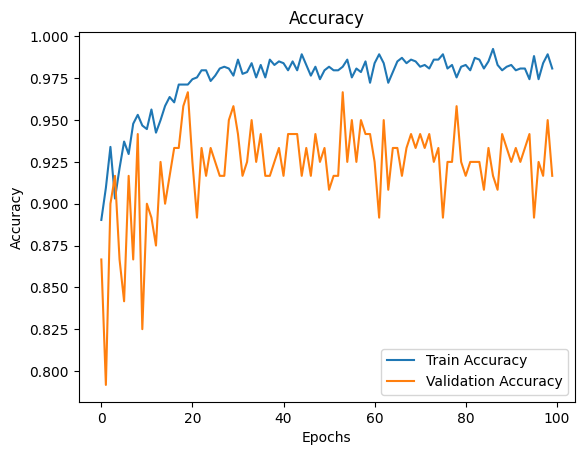

In [ ]:
# Model Training history Visualisations

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

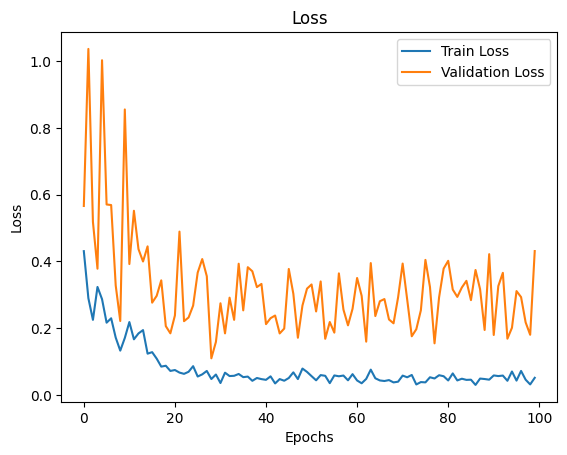

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()